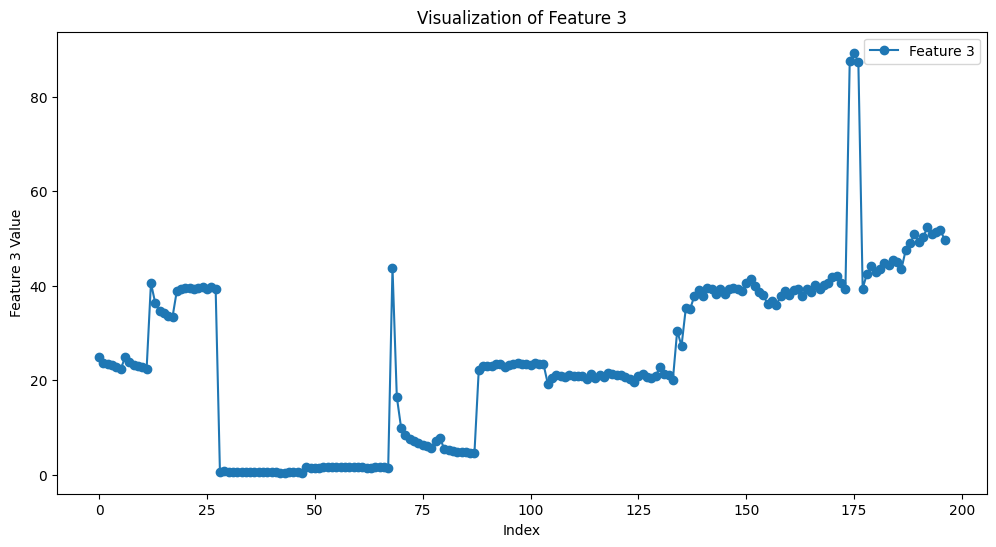

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def parse_dat_file(file_path):
    data = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ')
            label = parts[0]
            features = {int(feat.split(':')[0]): float(feat.split(':')[1]) for feat in parts[1:]}
            data.append(features)
            labels.append(label)

    df = pd.DataFrame(data).fillna(0)  # Fill in missing values to 0
    df['label'] = labels
    return df

file_path = '/content/drive/MyDrive/ColabNotebooks/MSCProject/DataSet/GasDataset/batch5.dat'
df = parse_dat_file(file_path)
# Select a dimension (such as the second feature) for visualization
feature_index = 3


feature_values = df[feature_index]
labels = df['label']


plt.figure(figsize=(12, 6))
plt.plot(feature_values, label=f'Feature {feature_index}', marker='o')
plt.title(f'Visualization of Feature {feature_index}')
plt.xlabel('Index')
plt.ylabel(f'Feature {feature_index} Value')
plt.legend()
plt.show()

In [ ]:
change_point = len(feature_values) // 2
before_change = feature_values[:change_point]
after_change = feature_values[change_point:]

mean_before = np.mean(before_change)
var_before = np.var(before_change)
mean_after = np.mean(after_change)
var_after = np.var(after_change)

print(f"Mean before change: {mean_before}, Variance before change: {var_before}")
print(f"Mean after change: {mean_after}, Variance after change: {var_after}")


Mean before change: 13.599378295918367, Variance before change: 202.7973820421983
Mean after change: 35.3900504040404, Variance after change: 193.3302690156887


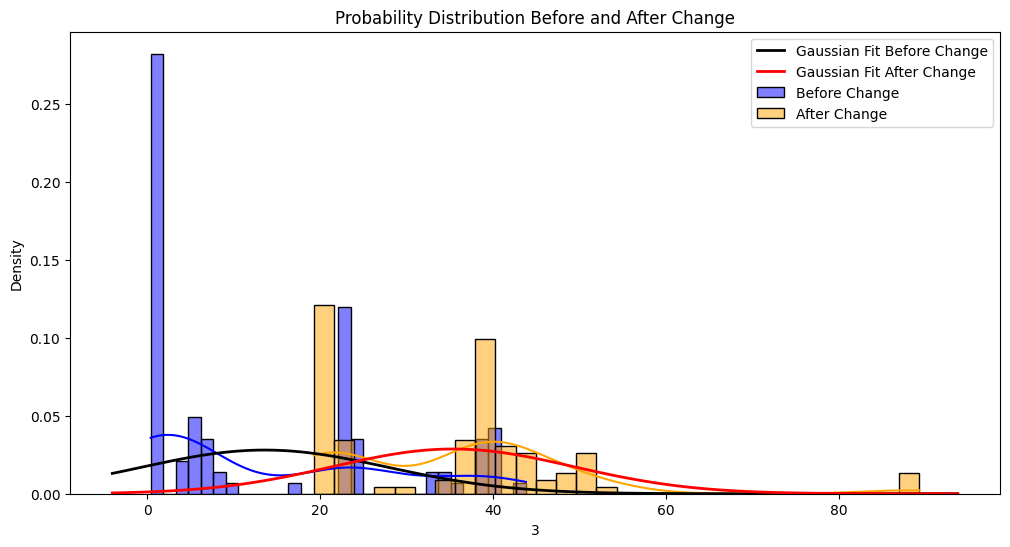

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Plot the probability distribution before and after the change
plt.figure(figsize=(12, 6))

sns.histplot(before_change, kde=True, stat="density", bins=30, label='Before Change', color='blue')
sns.histplot(after_change, kde=True, stat="density", bins=30, label='After Change', color='orange')

# 拟合高斯分布并绘制
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_before = norm.pdf(x, mean_before, np.sqrt(var_before))
p_after = norm.pdf(x, mean_after, np.sqrt(var_after))

plt.plot(x, p_before, 'k', linewidth=2, label='Gaussian Fit Before Change')
plt.plot(x, p_after, 'r', linewidth=2, label='Gaussian Fit After Change')

plt.title('Probability Distribution Before and After Change')
plt.legend()
plt.show()


In [ ]:
def cusum(data, h):
    s_pos = 0
    s_neg = 0
    k_pos = 0
    k_neg = 0
    detection_time = len(data)

    for i in range(1, len(data)):
        s_pos = max(0, s_pos + data[i] - mean_before - h)
        s_neg = min(0, s_neg + data[i] - mean_before + h)

        if s_pos > k_pos:
            k_pos = s_pos
        if s_neg < k_neg:
            k_neg = s_neg

        if s_pos >= h or s_neg <= -h:
            detection_time = i
            break
    return detection_time, s_pos, s_neg

# 设定阈值
thresholds = np.linspace(1.8, 25, 100)
for h in thresholds:
    detection_time, s_pos, s_neg = cusum(feature_values, h)
    delay = detection_time - change_point
    print(f"h = {h}, Detection Time = {detection_time}, Delay = {delay}")


h = 1.8, Detection Time = 1, Delay = -97
h = 2.0343434343434343, Detection Time = 1, Delay = -97
h = 2.268686868686869, Detection Time = 1, Delay = -97
h = 2.503030303030303, Detection Time = 1, Delay = -97
h = 2.7373737373737375, Detection Time = 1, Delay = -97
h = 2.971717171717172, Detection Time = 1, Delay = -97
h = 3.206060606060606, Detection Time = 1, Delay = -97
h = 3.44040404040404, Detection Time = 1, Delay = -97
h = 3.6747474747474747, Detection Time = 1, Delay = -97
h = 3.909090909090909, Detection Time = 1, Delay = -97
h = 4.143434343434343, Detection Time = 1, Delay = -97
h = 4.377777777777777, Detection Time = 1, Delay = -97
h = 4.612121212121212, Detection Time = 1, Delay = -97
h = 4.846464646464646, Detection Time = 1, Delay = -97
h = 5.08080808080808, Detection Time = 2, Delay = -96
h = 5.3151515151515145, Detection Time = 2, Delay = -96
h = 5.5494949494949495, Detection Time = 2, Delay = -96
h = 5.783838383838384, Detection Time = 2, Delay = -96
h = 6.018181818181818

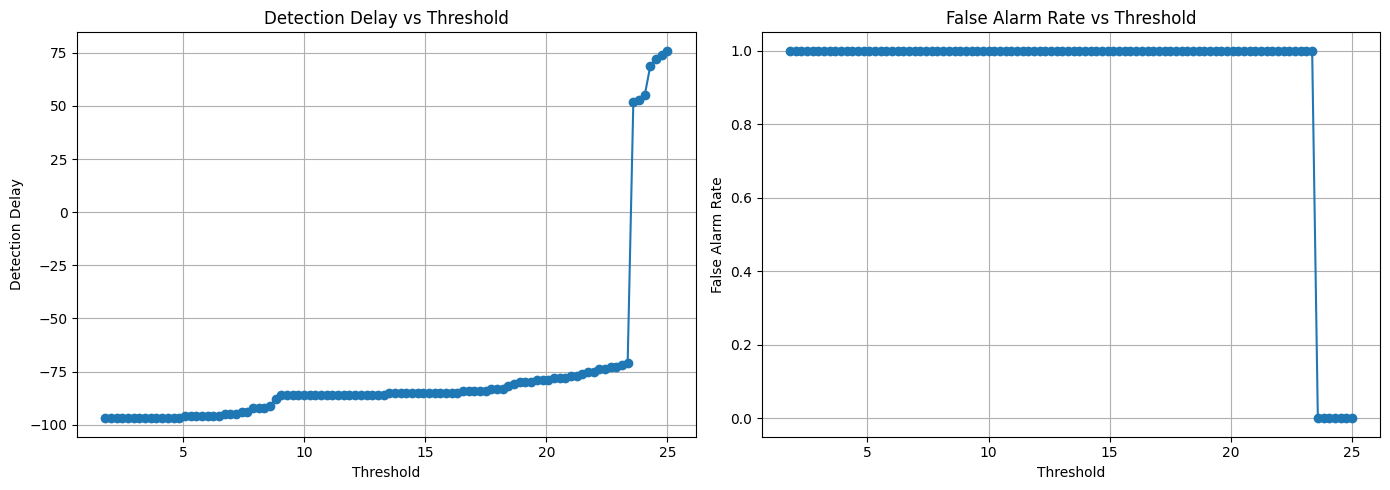

In [ ]:
delays = []
false_alarms = []

for h in thresholds:
    detection_time, s_pos, s_neg = cusum(feature_values, h)
    delay = detection_time - change_point
    delays.append(delay)
    false_alarm = 1 if detection_time < change_point else 0
    false_alarms.append(false_alarm)

# 绘制结果
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, delays, marker='o')
plt.title('Detection Delay vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Detection Delay')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, false_alarms, marker='o')
plt.title('False Alarm Rate vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('False Alarm Rate')
plt.grid(True)

plt.tight_layout()
plt.show()


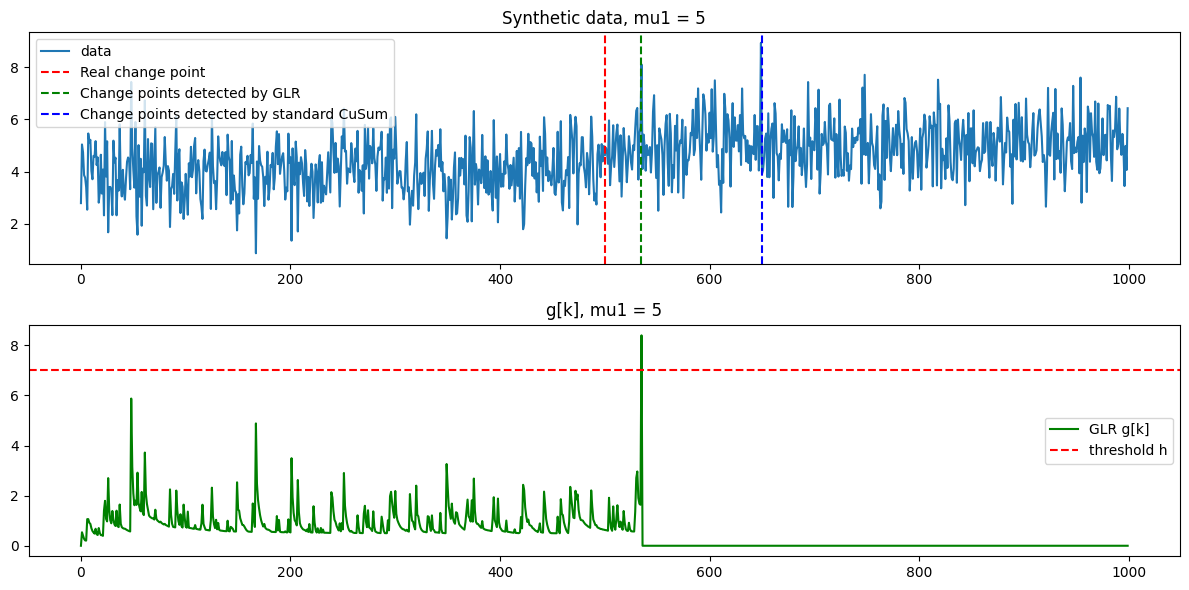

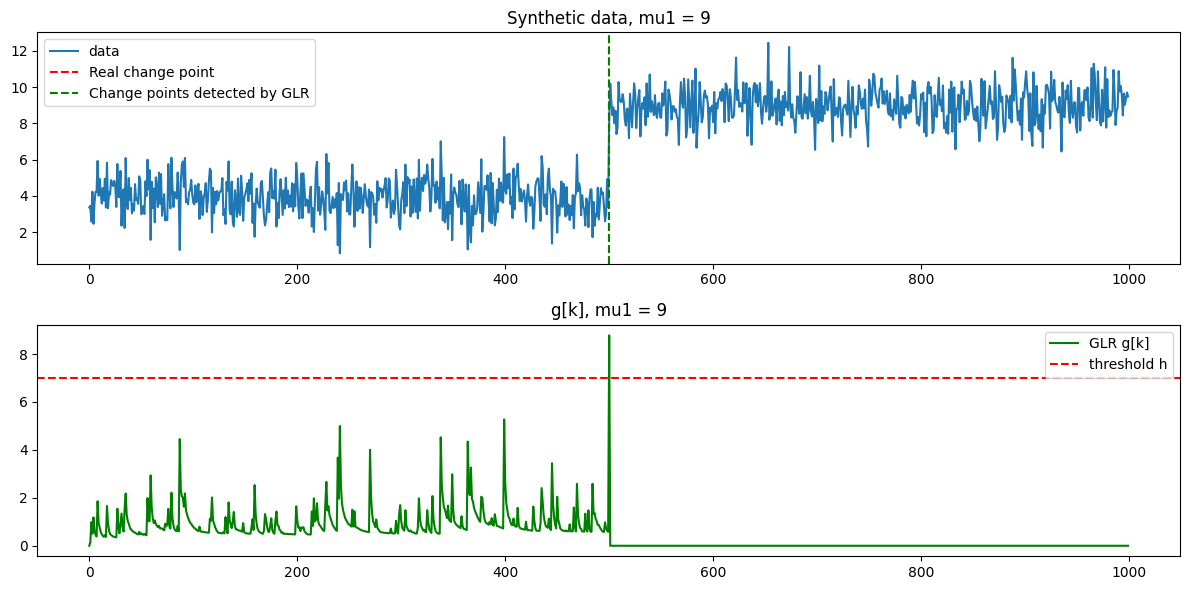

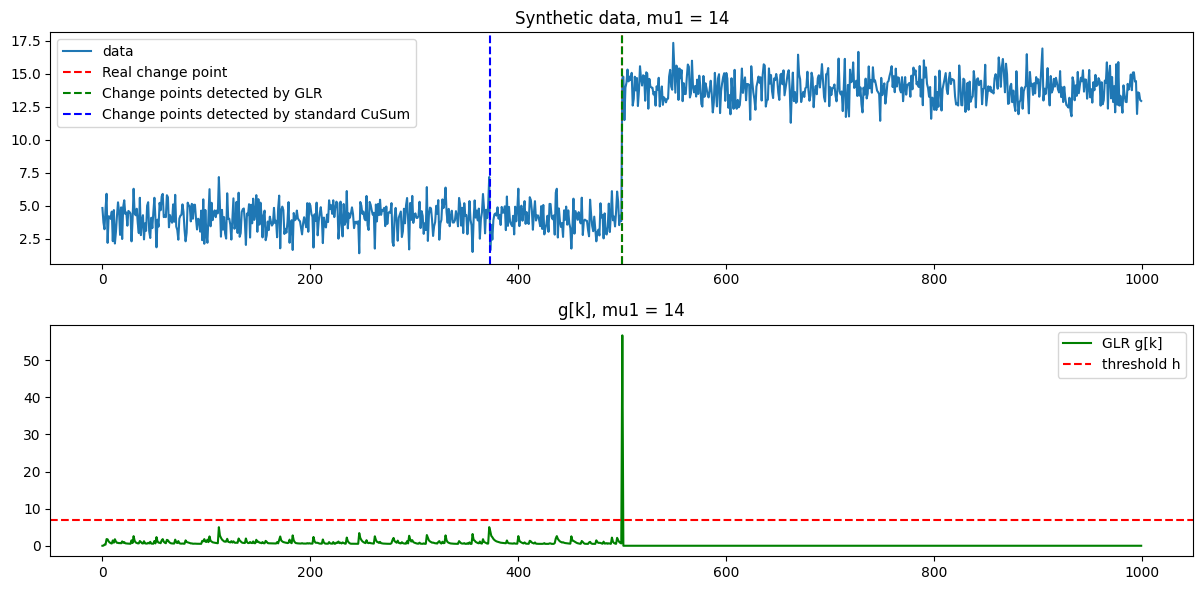

GLR/CuSum Average Detection Delay: 11.666666666666666
Standard CuSum Average Detection Delay: 11.5
GLR/CuSum False Alarm Rate: 0.0
Standard CuSum False Alarm Rate: 0.3333333333333333


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 数据生成函数
def generate_synthetic_data(n, change_point, mu0, sigma0, mu1):
    data = np.zeros(n)
    data[:change_point] = np.random.normal(mu0, sigma0, change_point)
    data[change_point:] = np.random.normal(mu1, sigma0, n - change_point)
    return data

# GLR-CuSum算法
def glr_cusum(data, mu0, sigma0, h):
    g = np.zeros(len(data))
    for k in range(1, len(data)):
        max_val = -np.inf
        for j in range(1, k+1):
            local_sum = np.sum((data[j:k+1] - mu0)**2)
            quantity = (1 / (k - j + 1)) * local_sum
            if quantity > max_val:
                max_val = quantity
        g[k] = (1 / (2 * sigma0**2)) * max_val
        if g[k] > h:
            return k, g
    return -1, g

# 标准CuSum算法
def standard_cusum(data, mu0, mu1, sigma0, h):
    s_pos, s_neg = 0, 0
    s_pos_list, s_neg_list = [], []
    for i in range(1, len(data)):
        s_pos = max(0, s_pos + data[i] - data[i-1] - h)
        s_neg = min(0, s_neg + data[i] - data[i-1] + h)
        s_pos_list.append(s_pos)
        s_neg_list.append(s_neg)
        if s_pos >= h or s_neg <= -h:
            return i, s_pos_list, s_neg_list
    return -1, s_pos_list, s_neg_list

# 参数设置
n = 1000
change_point = 500
mu0 = 4
sigma0 = 1
mu1_values = [5, 9, 14]
h = 7

# 初始化结果存储
results = {
    "GLR_CuSum": {"delays": [], "false_alarms": []},
    "Standard_CuSum": {"delays": [], "false_alarms": []}
}

# 尝试不同的mu1值
for mu1 in mu1_values:
    data = generate_synthetic_data(n, change_point, mu0, sigma0, mu1)

    # 运行GLR/CuSum算法
    detection_time_glr, g_glr = glr_cusum(data, mu0, sigma0, 6)
    if detection_time_glr != -1:
        delay_glr = detection_time_glr - change_point
        results["GLR_CuSum"]["delays"].append(delay_glr)
    else:
        results["GLR_CuSum"]["false_alarms"].append(1)

    # 运行标准CuSum算法
    detection_time_standard, s_pos_standard, s_neg_standard = standard_cusum(data, mu0, mu1, sigma0, 2.5)
    if detection_time_standard != -1:
        delay_standard = detection_time_standard - change_point
        results["Standard_CuSum"]["delays"].append(delay_standard)
    else:
        results["Standard_CuSum"]["false_alarms"].append(1)

    # 可视化结果
    plt.figure(figsize=(12, 6))

    # 原始数据
    plt.subplot(2, 1, 1)
    plt.plot(data, label='data')
    plt.axvline(change_point, color='r', linestyle='--', label='Real change point')

    if detection_time_glr != -1:
        plt.axvline(detection_time_glr, color='g', linestyle='--', label='Change points detected by GLR')
    if detection_time_standard != -1:
        plt.axvline(detection_time_standard, color='b', linestyle='--', label='Change points detected by standard CuSum')

    plt.title(f'Synthetic data, mu1 = {mu1}')
    plt.legend()

    # 绘制g[k]
    plt.subplot(2, 1, 2)
    plt.plot(g_glr, label='GLR g[k]', color='g')
    plt.axhline(h, color='r', linestyle='--', label='threshold h')
    plt.title(f'g[k], mu1 = {mu1}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 计算平均检测延迟和误报率
avg_delay_glr = np.mean(results["GLR_CuSum"]["delays"])
avg_delay_standard = np.mean(results["Standard_CuSum"]["delays"])
false_alarm_rate_glr = np.sum(results["GLR_CuSum"]["false_alarms"]) / len(mu1_values)
false_alarm_rate_standard = np.sum(results["Standard_CuSum"]["false_alarms"]) / len(mu1_values)

print(f"GLR/CuSum Average Detection Delay: {avg_delay_glr}")
print(f"Standard CuSum Average Detection Delay: {avg_delay_standard}")
print(f"GLR/CuSum False Alarm Rate: {false_alarm_rate_glr}")
print(f"Standard CuSum False Alarm Rate: {false_alarm_rate_standard}")

